## Open University Data Mining - features extractions and classifications
### By Liam Wang ,  4/8/2017

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sklearn
import collections

### 1. Demographic metrics

In [15]:
# Read in student demographic information 
info = pd.read_csv('studentInfo.csv')
info = info[[0,1,2,5,6,7,11]] #some columns are dropped
info.head()

,code_module,code_presentation,id_student,highest_education,imd_band,age_band,final_result
0,AAA,2013J,11391,HE Qualification,90-100%,55<=,Pass
1,AAA,2013J,28400,HE Qualification,20-30%,35-55,Pass
2,AAA,2013J,30268,A Level or Equivalent,30-40%,35-55,Withdrawn
3,AAA,2013J,31604,A Level or Equivalent,50-60%,35-55,Pass
4,AAA,2013J,32885,Lower Than A Level,50-60%,0-35,Pass


### 2. Assessment Metrics

In [16]:
# Read in assessment information, joining two files
assmt = pd.read_csv('assessments.csv')
student_assmt = pd.read_csv('studentAssessment.csv')[[0,1,2,4]] #some columns are dropped
assmt_combined = pd.merge(student_assmt, assmt, how = 'inner', on=['id_assessment'])

#Replacing ? with np.nan
#Converting to float for ease of calculations
a = assmt_combined['score'].values
a[a == '?'] = np.nan
assmt_combined['score'] = a

b = assmt_combined['date'].values
b[b == '?'] = np.nan
assmt_combined['date'] = b

assmt_combined[['date','score']] = assmt_combined[['date','score']].astype('float')

In [17]:
# extracting mean score
mean_score = assmt_combined.groupby(['id_student','code_module','code_presentation'], as_index=False).aggregate(np.mean)[[0,1,2,5]]
mean_score.rename(columns = {'score':'mean_score'}, inplace = True)

# extracting mean CMA
df = assmt_combined.groupby(['id_student','code_module','code_presentation','assessment_type'], as_index=False).aggregate(np.mean)
mean_CMA = df.loc[df['assessment_type'] == 'CMA'][[0,1,2,6]]
mean_CMA.rename(columns = {'score':'CMA_score'}, inplace = True)
#mean TMA
mean_TMA = df.loc[df['assessment_type'] == 'TMA'][[0,1,2,6]]
mean_TMA.rename(columns = {'score':'TMA_score'}, inplace = True)
#mean Exam
mean_Exam = df.loc[df['assessment_type'] == 'Exam'][[0,1,2,6]]
mean_Exam.rename(columns = {'score':'Exam_score'}, inplace = True)

#merging all of them together
df_all = pd.merge(mean_score, mean_CMA, how='left', on = ['id_student','code_module','code_presentation']).merge(
    mean_TMA, how = 'left', on = ['id_student','code_module','code_presentation']).merge(
    mean_Exam, how = 'left', on = ['id_student','code_module','code_presentation'])

df_all.head()

,id_student,code_module,code_presentation,mean_score,CMA_score,TMA_score,Exam_score
0,6516,AAA,2014J,61.800000,NaN,61.800000,NaN
1,8462,DDD,2013J,87.666667,NaN,87.666667,NaN
2,8462,DDD,2014J,86.500000,NaN,86.500000,NaN
3,11391,AAA,2013J,82.000000,NaN,82.000000,NaN
4,23629,BBB,2013B,82.500000,100.0,65.000000,NaN


### 3. Interaction and Contents Metrics

In [12]:
# days of early registration
early_reg = pd.read_csv('studentRegistration.csv')[[0,1,2,3]]

# read in vle information
vle1 = pd.read_csv('studentVle.csv')

#aggregate and extract sum of clicks
sum_clicks_all = vle1.groupby(['id_student','code_module','code_presentation'], as_index = False).sum()[[0,1,2,5]]

#sum of days extracted
sum_days = vle1.groupby(['id_student','code_module','code_presentation'], as_index = False)['date'].apply(lambda x: len(x.unique())).reset_index()
sum_days.rename(columns = {0:'days_interacted'}, inplace = True)

#daily clicks extracted
vle_clicks = pd.merge(sum_clicks_all, sum_days, how = 'inner', on = ['id_student','code_module','code_presentation'])
vle_clicks['daily_click'] = vle_clicks['sum_click']/vle_clicks['days_interacted']

#Extract material counts of each course module and semester
vle_type = pd.read_csv('vle.csv')[[0,1,2,3]]
vle_type = vle_type.groupby(['code_module','code_presentation','activity_type'], as_index=False).count()
vle_type.rename(columns = {'id_site':'count'}, inplace = True)

vle_pivot = pd.pivot_table(vle_type, index=['code_module','code_presentation'],columns='activity_type').reset_index()
vle_pivot.index.name = None
vle_pivot.columns = [' '.join(col).strip() for col in vle_pivot.columns.values]
vle_pivot.fillna(value=0, inplace = True)

#Merge all tables
vle_combined = pd.merge(vle_clicks, vle_pivot, how = 'inner')
vle_combined.head()

,id_student,code_module,code_presentation,sum_click,days_interacted,daily_click,count dataplus,count dualpane,count externalquiz,count folder,...,count ouelluminate,count ouwiki,count page,count questionnaire,count quiz,count repeatactivity,count resource,count sharedsubpage,count subpage,count url
0,6516,AAA,2014J,2791,159,17.553459,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93.0,0.0,6.0,20.0
1,24734,AAA,2014J,499,56,8.910714,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93.0,0.0,6.0,20.0
2,26192,AAA,2014J,2223,118,18.838983,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93.0,0.0,6.0,20.0
3,28061,AAA,2014J,1590,148,10.743243,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93.0,0.0,6.0,20.0
4,31600,AAA,2014J,429,19,22.578947,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,93.0,0.0,6.0,20.0


### 4. Merge demographic, assessment, interaction, materials contents

In [18]:
df_all = df_all.merge(info, how = 'right', on = ['id_student','code_module','code_presentation'])
df_all = df_all.merge(early_reg, how='left', on = ['id_student','code_module','code_presentation'])
df_all = df_all.merge(vle_combined, how='left', on = ['id_student','code_module','code_presentation'])

df_all.head()

,id_student,code_module,code_presentation,mean_score,CMA_score,TMA_score,Exam_score,highest_education,imd_band,age_band,...,count ouelluminate,count ouwiki,count page,count questionnaire,count quiz,count repeatactivity,count resource,count sharedsubpage,count subpage,count url
0,6516,AAA,2014J,61.800000,NaN,61.800000,NaN,HE Qualification,80-90%,55<=,...,0.0,0.0,0.0,0.0,0.0,0.0,93.0,0.0,6.0,20.0
1,8462,DDD,2013J,87.666667,NaN,87.666667,NaN,HE Qualification,30-40%,55<=,...,0.0,4.0,0.0,0.0,0.0,0.0,178.0,0.0,194.0,44.0
2,8462,DDD,2014J,86.500000,NaN,86.500000,NaN,HE Qualification,30-40%,55<=,...,0.0,1.0,0.0,0.0,0.0,0.0,169.0,0.0,110.0,46.0
3,11391,AAA,2013J,82.000000,NaN,82.000000,NaN,HE Qualification,90-100%,55<=,...,0.0,0.0,0.0,0.0,0.0,0.0,95.0,0.0,6.0,18.0
4,23629,BBB,2013B,82.500000,100.0,65.000000,NaN,Lower Than A Level,20-30%,0-35,...,1.0,0.0,0.0,0.0,5.0,0.0,236.0,1.0,37.0,15.0


In [19]:
# Display how many values are there in each column of final merged dataframe
df_all.count()

id_student              32593
code_module             32593
code_presentation       32593
mean_score              25820
CMA_score               15100
TMA_score               24788
Exam_score               4959
highest_education       32593
imd_band                32593
age_band                32593
final_result            32593
date_registration       32593
sum_click               29228
days_interacted         29228
daily_click             29228
count dataplus          29228
count dualpane          29228
count externalquiz      29228
count folder            29228
count forumng           29228
count glossary          29228
count homepage          29228
count htmlactivity      29228
count oucollaborate     29228
count oucontent         29228
count ouelluminate      29228
count ouwiki            29228
count page              29228
count questionnaire     29228
count quiz              29228
count repeatactivity    29228
count resource          29228
count sharedsubpage     29228
count subp

In [20]:
# save it as final_data.csv
df_all.to_csv('final_data.csv')

In [22]:
df_all = pd.read_csv('final_data.csv', na_values='?')
# rearranging column orders
df_all = df_all[['id_student', 'code_module', 'code_presentation', 'mean_score',
       'CMA_score', 'TMA_score', 'Exam_score', 'highest_education', 'imd_band',
       'age_band', 'date_registration', 'sum_click',
       'days_interacted', 'daily_click', 'count dataplus', 'count dualpane',
       'count externalquiz', 'count folder', 'count forumng', 'count glossary',
       'count homepage', 'count htmlactivity', 'count oucollaborate',
       'count oucontent', 'count ouelluminate', 'count ouwiki', 'count page',
       'count questionnaire', 'count quiz', 'count repeatactivity',
       'count resource', 'count sharedsubpage', 'count subpage', 'count url', 'final_result']]
df_all.head()

,id_student,code_module,code_presentation,mean_score,CMA_score,TMA_score,Exam_score,highest_education,imd_band,age_band,...,count ouwiki,count page,count questionnaire,count quiz,count repeatactivity,count resource,count sharedsubpage,count subpage,count url,final_result
0,6516,AAA,2014J,61.800000,NaN,61.800000,NaN,HE Qualification,80-90%,55<=,...,0.0,0.0,0.0,0.0,0.0,93.0,0.0,6.0,20.0,Pass
1,8462,DDD,2013J,87.666667,NaN,87.666667,NaN,HE Qualification,30-40%,55<=,...,4.0,0.0,0.0,0.0,0.0,178.0,0.0,194.0,44.0,Withdrawn
2,8462,DDD,2014J,86.500000,NaN,86.500000,NaN,HE Qualification,30-40%,55<=,...,1.0,0.0,0.0,0.0,0.0,169.0,0.0,110.0,46.0,Withdrawn
3,11391,AAA,2013J,82.000000,NaN,82.000000,NaN,HE Qualification,90-100%,55<=,...,0.0,0.0,0.0,0.0,0.0,95.0,0.0,6.0,18.0,Pass
4,23629,BBB,2013B,82.500000,100.0,65.000000,NaN,Lower Than A Level,20-30%,0-35,...,0.0,0.0,0.0,5.0,0.0,236.0,1.0,37.0,15.0,Fail


## 5. Preprocess final table

In [23]:
# read the parts of the final table that is useful
no_class_info = df_all.iloc[:,7:35]

#transform categorical education level to numbers
edulevel = list(no_class_info['highest_education'])
for i in range(len(edulevel)):
    if edulevel[i] == 'A Level or Equivalent':
        edulevel[i] = 2
    elif edulevel[i] == 'HE Qualification':
        edulevel[i] = 3
    elif edulevel[i] == 'Lower Than A Level':
        edulevel[i] = 1
    elif edulevel[i] == 'No Formal quals':
        edulevel[i] = 0
    elif edulevel[i] == 'Post Graduate Qualification':
        edulevel[i] = 4
edulevel[:10]

[3, 3, 3, 3, 1, 2, 2, 1, 2, 2]

In [24]:
# transform categorical imd band into numbers
imd_list = list(no_class_info['imd_band'])
for i,n in enumerate(imd_list):
    if n == '0-10%':
        imd_list[i] = 0
    elif n == '10-20':
        imd_list[i] = 1
    elif n == '20-30%':
        imd_list[i] = 2
    elif n == '30-40%':
        imd_list[i] = 3
    elif n == '40-50%':
        imd_list[i] = 4
    elif n == '50-60%':
        imd_list[i] = 5
    elif n == '60-70%':
        imd_list[i] = 6
    elif n == '70-80%':
        imd_list[i] = 7
    elif n == '80-90%':
        imd_list[i] = 8
    elif n == '90-100%':
        imd_list[i] = 9
    else:
        imd_list[i] = 0
imd_list[:10]

[8, 3, 3, 9, 2, 5, 5, 1, 4, 8]

In [25]:
# transform age into numbers
age_list = list(no_class_info['age_band'])
for i,n in enumerate(age_list):
    if n == '0-35':
        age_list[i] = 0
    elif n == '35-55':
        age_list[i] = 1
    elif n == '55<=':
        age_list[i] = 2
age_list[:10]

[2, 2, 2, 2, 0, 0, 0, 0, 0, 0]

In [26]:
# finalize final datset as "drop", taking out rows with any NAN values
no_class_info['date_registration'] = - no_class_info['date_registration'].values
no_class_info['highest_education'] = edulevel
no_class_info['age_band'] = age_list
no_class_info['imd_band'] = imd_list

drop = no_class_info.dropna(axis=0, how='any')
drop.drop(labels='count homepage', axis = 1)
del drop['count homepage']
drop.head()

,highest_education,imd_band,age_band,date_registration,sum_click,days_interacted,daily_click,count dataplus,count dualpane,count externalquiz,...,count ouwiki,count page,count questionnaire,count quiz,count repeatactivity,count resource,count sharedsubpage,count subpage,count url,final_result
0,3,8,2,52.0,2791.0,159.0,17.553459,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,93.0,0.0,6.0,20.0,Pass
1,3,3,2,137.0,646.0,56.0,11.535714,0.0,0.0,7.0,...,4.0,0.0,0.0,0.0,0.0,178.0,0.0,194.0,44.0,Withdrawn
2,3,3,2,38.0,10.0,1.0,10.000000,0.0,0.0,5.0,...,1.0,0.0,0.0,0.0,0.0,169.0,0.0,110.0,46.0,Withdrawn
3,3,9,2,159.0,934.0,40.0,23.350000,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,95.0,0.0,6.0,18.0,Pass
4,1,2,0,47.0,161.0,16.0,10.062500,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,236.0,1.0,37.0,15.0,Fail


## 6. Extracting X and Y, Pearson correlation and ANOVA

In [28]:
# get features X and label Y for machine learning models.
X = drop.iloc[:,:-1].values
Y = drop.iloc[:,-1].values
for i in range(len(Y)):
    if Y[i] == 'Pass':
        Y[i] = 1
    elif Y[i] == 'Distinction':
        Y[i] = 0
    elif Y[i] == 'Fail':
        Y[i] = 2
    elif Y[i] == 'Withdrawn':
        Y[i] = 3

In [29]:
# Examine correlations among columns and label 
drop['final_result'] = drop['final_result'].astype(int)
corr = drop.corr(method='pearson')
corr

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,highest_education,imd_band,age_band,date_registration,sum_click,days_interacted,daily_click,count dataplus,count dualpane,count externalquiz,...,count ouwiki,count page,count questionnaire,count quiz,count repeatactivity,count resource,count sharedsubpage,count subpage,count url,final_result
highest_education,1.000000,0.091127,0.108872,-0.043017,0.082067,0.117929,0.042590,-0.010565,-0.017206,0.038801,...,0.002604,-0.013542,-0.034205,0.011276,-0.022485,-0.047770,-0.062541,0.035203,-0.004036,-0.140862
imd_band,0.091127,1.000000,0.056071,-0.002664,0.046833,0.070107,0.017843,-0.003357,-0.012045,0.021925,...,-0.002143,-0.014186,-0.024583,-0.021454,-0.014415,-0.033299,-0.039324,0.011750,-0.012318,-0.092238
age_band,0.108872,0.056071,1.000000,-0.025059,0.140404,0.132496,0.096009,-0.022331,-0.049853,-0.037799,...,-0.071206,-0.053786,-0.046800,-0.007073,-0.041995,0.004684,0.028083,-0.057191,-0.062040,-0.066500
date_registration,-0.043017,-0.002664,-0.025059,1.000000,0.036160,0.065282,-0.012726,0.010568,0.006632,0.055942,...,0.015724,0.006903,0.001593,-0.009761,0.046895,0.020483,-0.026446,0.079979,0.017991,0.025617
sum_click,0.082067,0.046833,0.140404,0.036160,1.000000,0.827190,0.605141,0.370949,0.347839,-0.108286,...,0.301825,0.373370,0.359546,0.156202,0.255714,-0.133598,-0.151013,-0.021924,0.343850,-0.438317
days_interacted,0.117929,0.070107,0.132496,0.065282,0.827190,1.000000,0.283204,0.190375,0.167841,0.060133,...,0.209673,0.176494,0.157645,-0.016688,0.121377,-0.036140,-0.107877,0.093127,0.205208,-0.577072
daily_click,0.042590,0.017843,0.096009,-0.012726,0.605141,0.283204,1.000000,0.458490,0.443216,-0.248875,...,0.332987,0.479867,0.473959,0.289735,0.314633,-0.256842,-0.213141,-0.140910,0.394001,-0.150993
count dataplus,-0.010565,-0.003357,-0.022331,0.010568,0.370949,0.190375,0.458490,1.000000,0.840713,-0.294737,...,0.698150,0.916244,0.942190,0.372198,0.679615,-0.181884,-0.264159,-0.054623,0.882184,0.002691
count dualpane,-0.017206,-0.012045,-0.049853,0.006632,0.347839,0.167841,0.443216,0.840713,1.000000,-0.273085,...,0.718344,0.972302,0.852253,0.355421,0.657039,-0.132950,-0.244753,-0.047000,0.792576,0.001103
count externalquiz,0.038801,0.021925,-0.037799,0.055942,-0.108286,0.060133,-0.248875,-0.294737,-0.273085,1.000000,...,0.239443,-0.298590,-0.300661,-0.611838,-0.196146,0.370720,-0.213914,0.913414,0.061930,0.087869


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F280AE5240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001F283190F60>]], dtype=object)

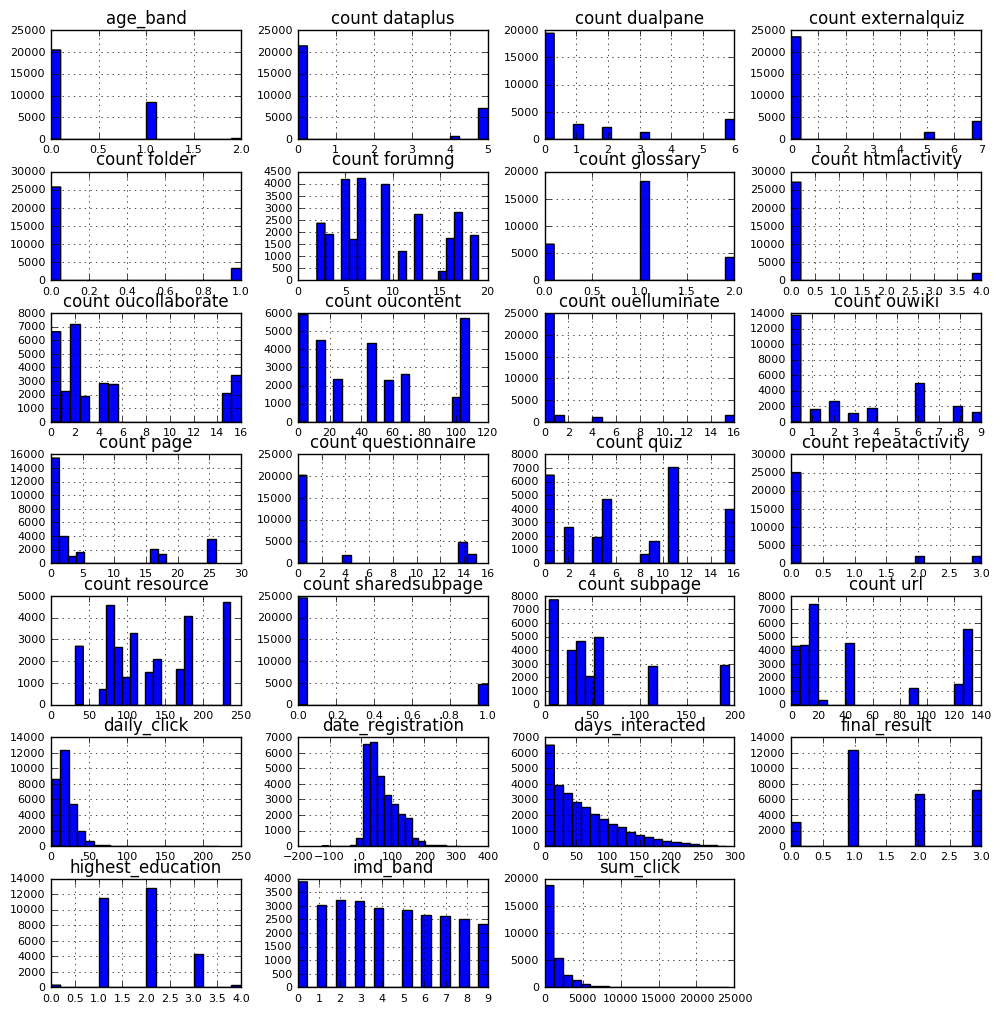

In [30]:
# histogram of values in each column
drop.hist(figsize=(12,16), layout=(9,4), xlabelsize=8, ylabelsize=8, bins = 20)

In [31]:
# normalize X
from sklearn.preprocessing import StandardScaler
X_norm = StandardScaler().fit_transform(X)

In [33]:
# calculate f score and p-value of each feature using ANOVA
# higher F and lower p-value indicates feature being more important
from sklearn.feature_selection import f_classif, SelectKBest
Fs, pval = f_classif(X_norm,Y)
print(Fs)
print(pval)

[  2.78290473e+02   1.07793400e+02   6.82772597e+01   3.53120495e+01
   2.52443089e+03   5.40489970e+03   2.58279869e+02   6.87385148e+00
   8.31306443e+00   7.74752386e+01   8.11432955e+00   3.17289580e+01
   8.36717835e+01   1.69309161e+01   1.59482749e+01   1.03152943e+01
   1.65103392e+01   2.88438334e+01   3.89441508e+00   2.93300734e+00
   7.50047080e+01   2.10393111e+00   4.52483010e+01   4.50862861e+01
   1.07402939e+02   3.24747863e+01]
[  4.06439709e-178   2.09123792e-069   5.42963246e-044   9.02799339e-023
   0.00000000e+000   0.00000000e+000   1.90343594e-165   1.26569656e-004
   1.59775179e-005   6.52106585e-050   2.12812211e-005   1.81574915e-020
   6.71718914e-054   5.53167086e-011   2.34124465e-010   8.79375768e-007
   1.02593773e-010   1.29575925e-018   8.55933677e-003   3.21029255e-002
   2.53689490e-048   9.74123576e-002   3.64841282e-029   4.63869699e-029
   3.72573516e-069   6.02164896e-021]


In [34]:
# filter out 10 most significant features of the 26 features
selectK = SelectKBest(f_classif, k = 10).fit(X_norm,Y)
selectK.get_support()

array([ True,  True,  True, False,  True,  True,  True, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False], dtype=bool)

In [35]:
X_best = selectK.transform(X_norm)
Y= np.asarray(Y, dtype=int)

## 7. Classification models - Naive Bayes, Logistic Regression, Random Forrest

In [36]:
# split the dataset into train and test sets randomly
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.30, random_state=0)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_best, Y, test_size=0.30, random_state=0)

### Naive Bayes: 0.49 testing accuracy

In [41]:
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB().fit(X_train, Y_train)

Y_train_pred = nb.predict(X_train)
Y_test_pred = nb.predict(X_test)

print("traning accuracy: {}, testing accuracy: {}".format(metrics.accuracy_score(Y_train, Y_train_pred),
                                                         metrics.accuracy_score(Y_test, Y_test_pred)))
print(metrics.classification_report(Y_train, Y_train_pred))
print(metrics.classification_report(Y_test, Y_test_pred))
print("confusion matrix: \n", metrics.confusion_matrix(Y_test,Y_test_pred))

traning accuracy: 0.48381734624034417, testing accuracy: 0.4909319037298962
             precision    recall  f1-score   support

          0       0.35      0.27      0.30      2119
          1       0.69      0.50      0.58      8644
          2       0.32      0.30      0.31      4680
          3       0.44      0.71      0.55      5011

avg / total       0.51      0.48      0.48     20454

             precision    recall  f1-score   support

          0       0.35      0.26      0.30       905
          1       0.69      0.51      0.59      3714
          2       0.34      0.32      0.33      1998
          3       0.45      0.71      0.55      2150

avg / total       0.51      0.49      0.49      8767

confusion matrix: 
 [[ 239  467   92  107]
 [ 396 1895  691  732]
 [  34  256  643 1065]
 [  17  141  465 1527]]


### Logistic Regression: 0.59 testing accuracy

In [42]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(C = 0.1, multi_class='multinomial', solver = 'newton-cg').fit(X_train, Y_train)

Y_train_pred2 = lg.predict(X_train)
Y_test_pred2 = lg.predict(X_test)

print("traning accuracy: {}, testing accuracy: {}".format(metrics.accuracy_score(Y_train, Y_train_pred2),
                                                         metrics.accuracy_score(Y_test, Y_test_pred2)))
print(metrics.classification_report(Y_train, Y_train_pred2))
print(metrics.classification_report(Y_test, Y_test_pred2))
print("confusion matrix: \n", metrics.confusion_matrix(Y_test, Y_test_pred2))

traning accuracy: 0.5966559108242886, testing accuracy: 0.5947302383939774
             precision    recall  f1-score   support

          0       0.55      0.07      0.13      2119
          1       0.64      0.85      0.73      8644
          2       0.45      0.26      0.33      4680
          3       0.58      0.69      0.63      5011

avg / total       0.57      0.60      0.55     20454

             precision    recall  f1-score   support

          0       0.50      0.06      0.11       905
          1       0.64      0.86      0.73      3714
          2       0.45      0.24      0.32      1998
          3       0.58      0.69      0.63      2150

avg / total       0.56      0.59      0.55      8767

confusion matrix: 
 [[  54  813   16   22]
 [  53 3198  269  194]
 [   2  653  489  854]
 [   0  358  319 1473]]


### Random Forest: 0.49 testing accuracy

In [48]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=7, max_features=5, n_estimators=1000, class_weight='balanced').fit(X_train, Y_train)

Y_train_pred3 = rf.predict(X_train)
Y_test_pred3 = rf.predict(X_test)

print("traning accuracy: {}, testing accuracy: {}".format(metrics.accuracy_score(Y_train, Y_train_pred3),
                                                         metrics.accuracy_score(Y_test, Y_test_pred3)))
print(metrics.classification_report(Y_train, Y_train_pred3))
print(metrics.classification_report(Y_test, Y_test_pred3))
print("confusion matrix: \n", metrics.confusion_matrix(Y_test, Y_test_pred3))

traning accuracy: 0.535689840617972, testing accuracy: 0.502452378236569
             precision    recall  f1-score   support

          0       0.31      0.74      0.44      2119
          1       0.70      0.49      0.58      8644
          2       0.46      0.38      0.42      4680
          3       0.62      0.67      0.64      5011

avg / total       0.58      0.54      0.54     20454

             precision    recall  f1-score   support

          0       0.27      0.68      0.39       905
          1       0.66      0.46      0.54      3714
          2       0.44      0.34      0.38      1998
          3       0.60      0.65      0.62      2150

avg / total       0.55      0.50      0.51      8767

confusion matrix: 
 [[ 617  244   25   19]
 [1431 1722  407  154]
 [ 160  408  679  751]
 [  75  242  446 1387]]


In [49]:
print(rf.feature_importances_)

[ 0.03265928  0.0124304   0.00437181  0.01647996  0.28926558  0.39480534
  0.05315684  0.00447497  0.00475996  0.00426234  0.00064384  0.01992249
  0.00715859  0.00052285  0.01037826  0.01532025  0.00221154  0.01321943
  0.013318    0.00341105  0.01946716  0.0004742   0.01531251  0.00428069
  0.02773038  0.02996227]


## 8. Analyze results from statistical tests and machine learning models
#### summarize top features that have most important impact on predicting students' performance - distinction, pass, failure, or withdraw

In [51]:
column_means = X.mean(axis=0)
column_stds = X.std(axis=0)

Top features in correlation results:

In [52]:
top_features = []

corr_results = dict(corr.iloc[26])
top_features.extend([k for k in sorted(corr_results, key=corr_results.get, reverse=True)][:10])

[(k, corr_results[k]) for k in sorted(corr_results, key=corr_results.get, reverse=True)]

[('final_result', 1.0),
 ('count subpage', 0.10412079067684751),
 ('count externalquiz', 0.08786947677129775),
 ('count url', 0.055699420314541385),
 ('count forumng', 0.054867219522098554),
 ('count ouwiki', 0.047627465695135311),
 ('count quiz', 0.036936574218751815),
 ('count oucollaborate', 0.033911257999888457),
 ('count resource', 0.025777409261942785),
 ('date_registration', 0.025617114684276025),
 ('count page', 0.013924552828010183),
 ('count folder', 0.013167090171684421),
 ('count questionnaire', 0.010382319302433095),
 ('count ouelluminate', 0.0093602666829254826),
 ('count oucontent', 0.0080925120006923364),
 ('count htmlactivity', 0.0080825428361700775),
 ('count repeatactivity', 0.0073159366060555628),
 ('count dataplus', 0.0026908782294207834),
 ('count dualpane', 0.0011028194121988182),
 ('count glossary', -0.034097890326787776),
 ('count sharedsubpage', -0.04221015905771331),
 ('age_band', -0.066499796926851054),
 ('imd_band', -0.092237991115877938),
 ('highest_educat

Top features in ANOVA tests

In [841]:
index = drop.columns[selectK.get_support()]
anova_top10 = {}
for i in range(10):
    anova_top10[index[i]] = pval[i]
    
top_features.extend([k for k in sorted(anova_top10, key=anova_top10.get, reverse=False)])
[(k, anova_top10[k]) for k in sorted(anova_top10, key=anova_top10.get, reverse=False)]

C:\Users\Administrator\Anaconda3\lib\site-packages\pandas\indexes\base.py:1434: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 27 but corresponding boolean dimension is 26
  result = getitem(key)


[('days_interacted', 0.0),
 ('daily_click', 0.0),
 ('highest_education', 4.0643970859196345e-178),
 ('count externalquiz', 1.9034359420956929e-165),
 ('imd_band', 2.0912379150998403e-69),
 ('count subpage', 6.5210658511451561e-50),
 ('age_band', 5.4296324586747911e-44),
 ('sum_click', 9.0279933874513522e-23),
 ('count quiz', 1.5977517881293157e-05),
 ('count glossary', 0.00012656965610212363)]

Top features according to random forest feature importances:

In [842]:
index = drop.columns
rf_feature_sort = {}
for i in range(len(rf.feature_importances_)):
    rf_feature_sort[index[i]] = rf.feature_importances_[i]

top_features.extend([k for k in sorted(rf_feature_sort, key=rf_feature_sort.get, reverse=True)][:10]) 
[(k, rf_feature_sort[k]) for k in sorted(rf_feature_sort, key=rf_feature_sort.get, reverse=True)]

[('days_interacted', 0.41197462857319966),
 ('sum_click', 0.29471797983623577),
 ('daily_click', 0.044378195092469784),
 ('highest_education', 0.03295324420415708),
 ('count url', 0.029940463270458149),
 ('count subpage', 0.028354466621694094),
 ('count forumng', 0.02102885356769606),
 ('count quiz', 0.02043990958671137),
 ('count resource', 0.01459855946164075),
 ('count oucontent', 0.014549040936821687),
 ('count ouwiki', 0.014016280253620294),
 ('count page', 0.013692211371529822),
 ('count oucollaborate', 0.010076500619613292),
 ('date_registration', 0.0087433002793350072),
 ('imd_band', 0.0083614435271204598),
 ('count glossary', 0.0065583026962700757),
 ('count sharedsubpage', 0.0047061044392538312),
 ('count dualpane', 0.0042825097284476463),
 ('count externalquiz', 0.0042782161234453473),
 ('count dataplus', 0.0034515261382292426),
 ('count questionnaire', 0.0028194737180522026),
 ('age_band', 0.0025667512610605143),
 ('count ouelluminate', 0.0020011969778336853),
 ('count fold

Voting mechanism: features below have the most votes according to three models

In [850]:
ct = collections.Counter(top_features)
ct.most_common(10)

[('count subpage', 3),
 ('count quiz', 3),
 ('count resource', 2),
 ('daily_click', 2),
 ('sum_click', 2),
 ('count externalquiz', 2),
 ('days_interacted', 2),
 ('count url', 2),
 ('highest_education', 2),
 ('count forumng', 2)]